In [1]:
%%time
from analysis_utils import *
import numpy as np
%load_ext autoreload
import pandas as pd
scalingFactor = 200
rxndiff=dict()

print('Starting scaling = ', scalingFactor)
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


#Growth rate = 3.0
path = "/Users/Akshay/Documents/TranslationDynamics/data/"

gr_sim = dict()

data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 1e15, 1e15, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor, NR_scaling = NR_scaledrates)
    gr_sim[i] = (CellLatencies(sim_i))


gr_dict = {'gr_1':gr_sim}

def computedElongationLatency_gr3_v2(gr25_ptRNA,gr25_pCodon,gr_dict):
    import numpy as np

    transportRxnResults = transportRxnCalc(gr_dict,gr25_ptRNA,gr25_pCodon)

    search_list = transportRxnResults[0]
    rxndiff['30'] = transportRxnResults[1:]
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

Starting scaling =  200
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 54.2 s, sys: 640 ms, total: 54.8 s
Wall time: 55.7 s


In [2]:
###### Genetic algorithm for just tRNA shuffling ########

def run_ga(gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,mintRNA,maxtRNA):
    
    #### Compute fitness
    fitness = (np.array(elong_t_tRNA_list))/sum((1/np.array(elong_t_tRNA_list)))

    #### Number of candidates n removing as well as n mating to create n offspring
    n = 10

    #### Identify the least fit candidates from the population
    cull_indices = np.argpartition(fitness, n)[:n]

    #### Choose parents based on weighting fitness
    import random
    #parent_indices = np.array(random.choices(np.arange(len(p_tRNA_list)), fitness, k=10))
    parent_indices = np.argpartition(fitness, n)[-n:]
    p_tRNA_list=np.array(p_tRNA_list)
    parents = p_tRNA_list[parent_indices]

    #### Mate k random pairs of 2 without replacement and renormalize
    k=5
    couples = np.random.choice(np.arange(len(parents)), size = (k,2),replace=False)
    recombination_rate = 0.1
    mutation_rate  = 0.05

    recombined_children = list()
    recombined_children_elongt = list()
    for couple_index in couples:
        couple = parents[couple_index]
        recombination_num = int(len(couple[0])*recombination_rate)
        recombination_locs = np.random.choice(len(couple[0]),recombination_num)
        recombination_values_0 = couple[0][recombination_locs] 
        couple[0][recombination_locs] = couple[1][recombination_locs]
        couple[1][recombination_locs] = recombination_values_0
        
        #### Mutate children
        mutation_num = int(len(couple[0])*mutation_rate)
        recombination_locs = np.random.choice(len(couple[0]),mutation_num)
        couple[0][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        couple[1][recombination_locs] = np.random.uniform(mintRNA,maxtRNA,mutation_num)
        
        ### Re-normalize each recombined children
        child_0 = couple[0]/np.sum(couple[0])
        child_1 = couple[1]/np.sum(couple[1])

        #### Compute elong_t of the recombined children
        elong_t_0, std_0 = computedElongationLatency_gr3_v2(child_0,gr25_pCodon,gr_dict);
        elong_t_1, std_1 = computedElongationLatency_gr3_v2(child_1,gr25_pCodon,gr_dict);
                

        ### Add children to list as well as their elong_t
        recombined_children.append(list(child_0))
        recombined_children.append(list(child_1))
        recombined_children_elongt.append(elong_t_0[0])
        recombined_children_elongt.append(elong_t_1[0])

    #### Have recombined children and their elong_t replaced culled candidates
    p_tRNA_list[cull_indices] = recombined_children
    elong_t_tRNA_list[cull_indices] = recombined_children_elongt
    return fitness, p_tRNA_list, elong_t_tRNA_list

    

In [ ]:
%%time
### Codon array fixed
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)
elong_t_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_elong_t_list.npy')
p_tRNA_list = np.load('RandomtRNA_FixedCodon_100sample_p_Codon_tRNA_list.npy')


fitness_arr = list()
minelong_arr = list()
elong_t_tRNA_list_arr = list()
for i in range(1500):
    fitness, p_tRNA_list, elong_t_tRNA_list = run_ga(gr25_Codon,elong_t_tRNA_list,p_tRNA_list,gr_dict,min(gr25_ptRNA),max(gr25_ptRNA))
    print(max(fitness))
    print(min(elong_t_tRNA_list))
    fitness_arr.append(max(fitness))
    minelong_arr.append(min(elong_t_tRNA_list))
    elong_t_tRNA_list_arr.append(elong_t_tRNA_list)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2',elong_t_tRNA_list)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_p_tRNA_list2',p_tRNA_list)
np.save('Slower_minelong_arr2-tRNA',minelong_arr)
np.save('Slower_RandomtRNA_FixedCodon_1500sample_elong_t_list2_arr-tRNA',elong_t_tRNA_list_arr)

463.70477767441906
203.90277475184288
466.2883082880637
206.2592504867959
468.49731516024303
208.7143394964597
475.5045339642341
210.1237345117109
485.2615722598898
210.6142284156151
486.88847416954457
211.45220044028173
488.695884859367
212.6791775357328
490.42536299076767
213.25882100939322
491.9448343987231
214.06599617862912
493.19487356177285
214.72042652460496
494.34520160580024
214.50845435346906
494.9966365485063
212.95315129057195
495.70716513858946
213.396351804709
496.3302118436215
213.76446036225624
496.8590816829837
213.87867597025314
497.20759938269197
216.31535698835302
497.99947343619544
213.6802420846844
498.35212952687766
214.70090034545757
499.30472945523434
217.76938554982894
506.09951303463356
219.1396609290869
507.3062133381329
219.40831505845864
515.6578226122449
215.61799864290174
516.7700117267678
220.40062156471194
518.4709540570309
220.13651967056194
519.5692217439288
218.93902321928766
520.8100762711441
221.7240920352858
522.0078478534365
221.75591582300154


592.5795064739241
235.76081873968548
592.3857550984226
237.79908254882443
592.6222369370945
234.36925418608556
592.1292265930429
238.43867597670297
592.5813531457035
232.7168352851466
592.0738122922096
235.4599309550199
592.3480567610414
234.57533974755728
592.23279168565
229.80026830144544
592.2908036381095
234.25895569617265
592.2011541067783
239.43547904458336
592.6695595811875
236.2210125290952
592.6877769963096
236.92847989453898
592.6300532098502
240.5519096431553
593.0420705543554
235.8990899358918
592.8207318353767
238.2470355488637
592.919183482194
234.96384522446098
592.6857811737563
233.53130880985867
592.5744567499901
228.41900385818818
592.4304780532046
232.40188926093316
592.5397574838165
234.6518737090762
592.675043704118
241.18477733624098
593.5797285507339
232.232053457653
592.988169165845
236.6760655079605
593.11168858558
237.2911687544705
593.2551554553852
238.24015359380812
593.6093577720446
234.10753780017706
593.3139048883145
234.79668238364474
593.1108089528997
2

606.8455363456878
236.25734567532012
606.7900234715738
234.59563370774873
606.7408237880622
240.86360513953525
607.5862204022752
238.2646635436941
607.3071777433332
235.26520120937926
606.9054204045503
238.06234511418018
607.3420739878866
236.45401046362772
607.2099972374964
239.64878503968202
607.3526148038743
237.8865168254537
606.8565155633667
239.49472866226031
607.3502951351446
240.22917585835557
607.4659137919978
237.0593373443938
607.1501584513536
238.51883645331566
607.2511212243181
237.87044602907577
607.3447725748025
241.27457647526947
607.6458693701126
238.06776606034776
607.16772129291
236.77649651241774
607.4408598065125
239.26066053194646
607.6191396079716
243.27164317220428
607.9872362975037
238.00451731453126
607.8253148553559
239.93206179382625
608.0662392525909
231.9185519897125
607.4792559603146
237.4567275987181
607.8007217321011
239.2528982192207
607.9018061569235
236.07651375914097
607.2821302576256
237.3317076016762
607.5452677286845
234.42843992271762
607.511745

612.4312906705622
238.63594022394918
612.4734662340832
241.52106419900875
612.5372430462288
240.35926580745533
612.2861500810342
234.07122890211082
612.2883570971218
239.9100637499971
612.4043971558475
240.90404350896475
612.5742504542179
234.7690529119226
612.1884557046443
237.46189109192878
612.406682655643
241.73047057441354
612.8910594560382
245.58915003920487
613.0475697380845
240.3108957412418
612.5540831443714
244.05639172221242
612.9124412281691
237.5646388013234
611.826622753807
235.076286980317
612.3831839842002
240.04097598223007
612.3415373318221
235.65087946190093
612.3703094265663
240.2162895265361
612.4604414227226
244.030571379575
613.0297259190844
240.24432747798772
612.5579680759195
243.37004027763354
612.7917424566582
238.90559471084796
612.285236851553
231.3880999222101
611.9674295688709
242.20123574397684
612.5003183652424
242.30265569630413
612.8113395345156
237.85325863497908
611.9579552809745
237.51573081816238
612.2274795079356
238.1308412058753
612.28081700857

616.0901389142658
240.94864799796775
615.8380295586092
238.68831292063518
615.7156778516601
238.05209577624493
615.8657547695593
239.24299737372684
615.6453174128764
240.88630118955268
615.703682571733
238.86940040168383
615.2695903385874
242.56535619940072
616.6266721574686
243.12850409721412
616.4116917250245
245.36881910667915
616.4890955724518
239.1861889782753
615.9855534417326
238.8958247674099
615.9879916760428
240.39938112359087
616.1812009214976
240.26829463966945
615.9118322548235
233.94263238606254
615.1787875387322
238.8918121413688
615.905506743756
245.67644760409647
616.630208895357
234.15410185193969
616.0082487040356
240.23130367295747
616.1438671945292
235.82822787560346
615.9360877787274
242.0252725492596
616.2358572984845
243.87284827263315
616.5689522142413
234.00744015099124
615.5937026458215
241.95164470052495
616.1551764236829
242.28760503968735
616.3164763766756
238.4119705440321
616.099819963043
236.19682228150316
615.5738657484341
242.68310581340373
616.498340

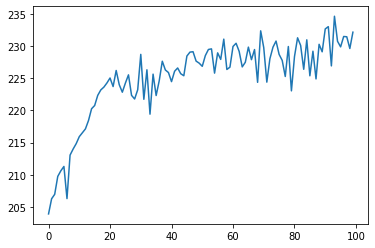

In [5]:
plt.plot(minelong_arr)

In [9]:
print(len(elong_t_tRNA_list_arr))

5
